In [34]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import pandas as pd

from src.data.load_data import load_test_data, load_training_data, load_group_centroids
from src.data.data_preprocessing import create_dt_dataset

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

# 1.1 Carga del dataset
Importamos el conjunto de interacciones usuario–película desde `data/train` usando las funciones definidas en `src/data/load_data` para mantener intactas las secuencias y las calificaciones originales.

Este notebook examina el DataFrame de entrenamiento con el que se entrenará el Decision Transformer. Primero lo cargamos desde `../data/train/` con `load_training_data`, lo que nos devolverá un objeto listo para trabajar.

In [35]:
training_data = load_training_data()

In [36]:
training_data

,user_id,user_group,items,ratings
0,0,0,"[472, 97, 122, 654, 709, 467, 574, 544, 478, 3...","[4.0, 3.0, 4.0, 3.0, 5.0, 4.0, 2.0, 1.0, 4.0, ..."
1,1,0,"[431, 445, 367, 100, 743, 739, 263, 426, 321, ...","[3.0, 5.0, 5.0, 5.0, 5.0, 3.0, 1.0, 4.0, 5.0, ..."
2,2,0,"[224, 133, 227, 51, 230, 546, 57, 60, 743, 495...","[5.0, 4.0, 3.0, 5.0, 4.0, 3.0, 4.0, 5.0, 5.0, ..."
3,3,0,"[338, 80, 210, 618, 468, 320, 351, 411, 575, 2...","[3.0, 5.0, 3.0, 5.0, 2.0, 1.0, 4.0, 3.0, 3.0, ..."
4,4,0,"[510, 231, 708, 86, 514, 352, 233, 351, 415, 6...","[4.0, 2.0, 3.0, 4.0, 5.0, 4.0, 2.0, 4.0, 3.0, ..."
...,...,...,...,...
15995,15995,7,"[503, 434, 631, 301, 142, 355, 80, 191, 310, 3...","[1.0, 1.0, 4.0, 3.0, 3.0, 2.0, 2.0, 1.0, 4.0, ..."
15996,15996,7,"[263, 76, 247, 324, 733, 57, 658, 25, 680, 282...","[2.0, 1.0, 1.0, 3.0, 1.0, 2.0, 2.0, 2.0, 1.0, ..."
15997,15997,7,"[517, 212, 79, 151, 644, 612, 324, 322, 248, 6...","[2.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 2.0, 3.0, ..."
15998,15998,7,"[602, 534, 312, 16, 590, 330, 100, 364, 353, 2...","[1.0, 1.0, 2.0, 1.0, 3.0, 2.0, 4.0, 4.0, 2.0, ..."


# 1.2 Análisis exploratorio del dataset
Veremos la estructura y distribución de columnas para entender tamaños de secuencia, calificaciones y balance entre grupos de usuarios antes del preprocesamiento.

#### Columnas y cantidad de elementos

Revisamos la estructura base del DataFrame antes de transformar las secuencias. Las columnas son:
- `user_id (int64)`: identificador único de usuario (0–15999).
- `user_group (int64)`: cluster asignado a cada usuario (0–7) obtenido por preferencia de consumo.
- `items`: array de `item_id` (0–751) en orden temporal; cada valor es una película distinta.
- `ratings`: calificaciones alineadas con cada `item_id` (1.0–5.0), en el mismo orden temporal.

Sobre esta estructura medimos cantidad de filas, tipos, valores faltantes y balance de grupos para detectar sesgos tempranos.

In [37]:
print("Columnas en el conjunto de datos: ", training_data.columns)

print(training_data.count())

print("\nInformación del conjunto de datos:")
print(f"Forma del DataFrame: {training_data.shape}")
print(f"\nTipos de datos:")
print(training_data.dtypes)
print(f"\nValores faltantes por columna:")
print(training_data.isnull().sum())


Columnas en el conjunto de datos:  Index(['user_id', 'user_group', 'items', 'ratings'], dtype='object')
user_id       16000
user_group    16000
items         16000
ratings       16000
dtype: int64

Información del conjunto de datos:
Forma del DataFrame: (16000, 4)

Tipos de datos:
user_id        int64
user_group     int64
items         object
ratings       object
dtype: object

Valores faltantes por columna:
user_id       0
user_group    0
items         0
ratings       0
dtype: int64


In [38]:
# vemos los grupos de usuarios
print(training_data.user_group.unique())
print(f"Cantidad de usuarios por grupo:\n{training_data['user_group'].value_counts().sort_index()}")


[0 1 2 3 4 5 6 7]
Cantidad de usuarios por grupo:
user_group
0    2000
1    2000
2    2000
3    2000
4    2000
5    2000
6    2000
7    2000
Name: count, dtype: int64


In [39]:
# chequear el formato en que se presentan los items
training_data.sample(1)['items'].values[0]

array([582, 710, 502, 300, 203,  66, 191, 121, 485, 145, 336, 413, 337,
       323,  87,  25, 471, 461, 134, 539, 473, 422, 215,  47, 157, 222,
       531, 569, 341, 403, 555, 306, 428, 365, 524,  39, 551, 440, 605,
       346, 366,   0, 189, 589, 350, 269, 745, 508, 496, 656, 574, 272,
        32, 372, 303, 550, 427, 271, 329, 291, 719, 626, 659, 354,  27,
       181, 744, 487, 280, 689, 597, 120, 431, 101, 688, 681, 651, 500,
       611, 194, 601, 665])

In [40]:
# chequear el formato en que se presentan los ratings
training_data.sample(1)['ratings'].values[0]

array([5., 4., 2., 2., 3., 3., 4., 4., 4., 4., 5., 4., 5., 5., 4., 4., 5.,
       5., 4., 4., 5., 5., 5., 5., 1., 5., 5., 3., 3., 4., 4., 5., 5., 2.,
       4., 5., 5., 4., 1., 5., 4., 5., 5., 4., 2., 4., 4., 5., 4., 4., 5.,
       2., 5., 5., 2., 4., 2., 4., 4., 5., 3., 5., 2., 5., 5., 5., 5., 4.,
       4., 4., 4., 1., 5., 5., 5., 3., 5., 5., 5., 5., 5., 4., 5., 5., 5.,
       5., 5., 4., 5., 4., 5., 1., 4., 3., 5., 5., 4., 5., 5., 3., 5., 5.,
       4., 4., 4., 5., 5., 5., 5., 2., 3., 2., 5., 3., 3., 5., 5., 5., 5.,
       5., 4., 3., 4., 5., 3., 3., 3., 4., 5., 5., 5., 3., 3., 4., 4., 2.,
       4., 4., 2., 5., 3., 5., 5., 5., 5., 5., 3., 4., 4., 4., 3., 2., 4.,
       5., 1., 2., 4., 4.])

Longitud mínima de secuencia: 25
Longitud máxima de secuencia: 200
Longitud promedio de secuencia: 112.35075


<Axes: xlabel='len_sequence', ylabel='Count'>

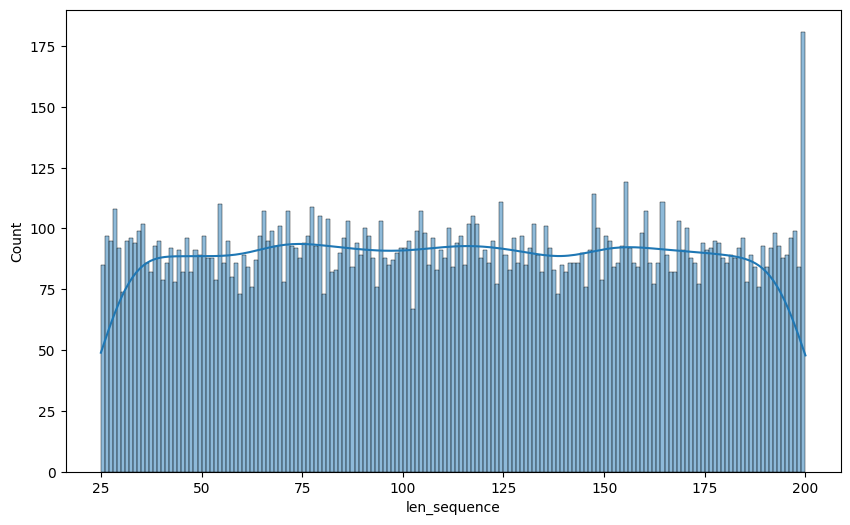

In [41]:
training_data['len_sequence'] = training_data['items'].apply(len)
print(f"Longitud mínima de secuencia: {training_data['len_sequence'].min()}")
print(f"Longitud máxima de secuencia: {training_data['len_sequence'].max()}")
print(f"Longitud promedio de secuencia: {training_data['len_sequence'].mean()}")

fig = plt.figure(figsize=(10, 6))
sns.histplot(training_data['len_sequence'], bins=175, kde=True)

Calificación mínima promedio por usuario: 1.5277777777777777
Calificación máxima promedio por usuario: 4.72
Calificación promedio promedio por usuario: 3.218076459284449


<Axes: xlabel='average_user_rating', ylabel='Count'>

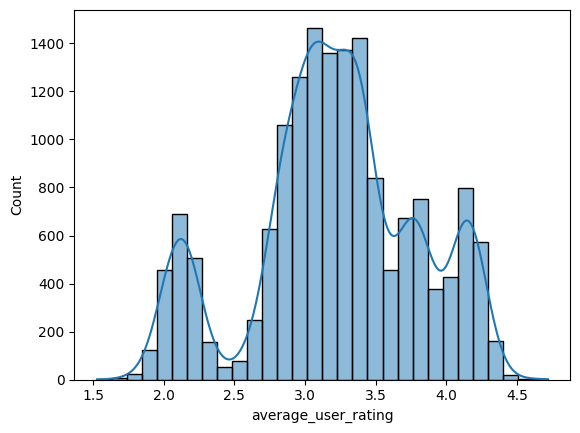

In [42]:
training_data['average_user_rating'] = training_data['ratings'].apply(lambda x: sum(x)/len(x))
print(f"Calificación mínima promedio por usuario: {training_data['average_user_rating'].min()}")
print(f"Calificación máxima promedio por usuario: {training_data['average_user_rating'].max()}")
print(f"Calificación promedio promedio por usuario: {training_data['average_user_rating'].mean()}")

sns.histplot(training_data['average_user_rating'], bins=30, kde=True)

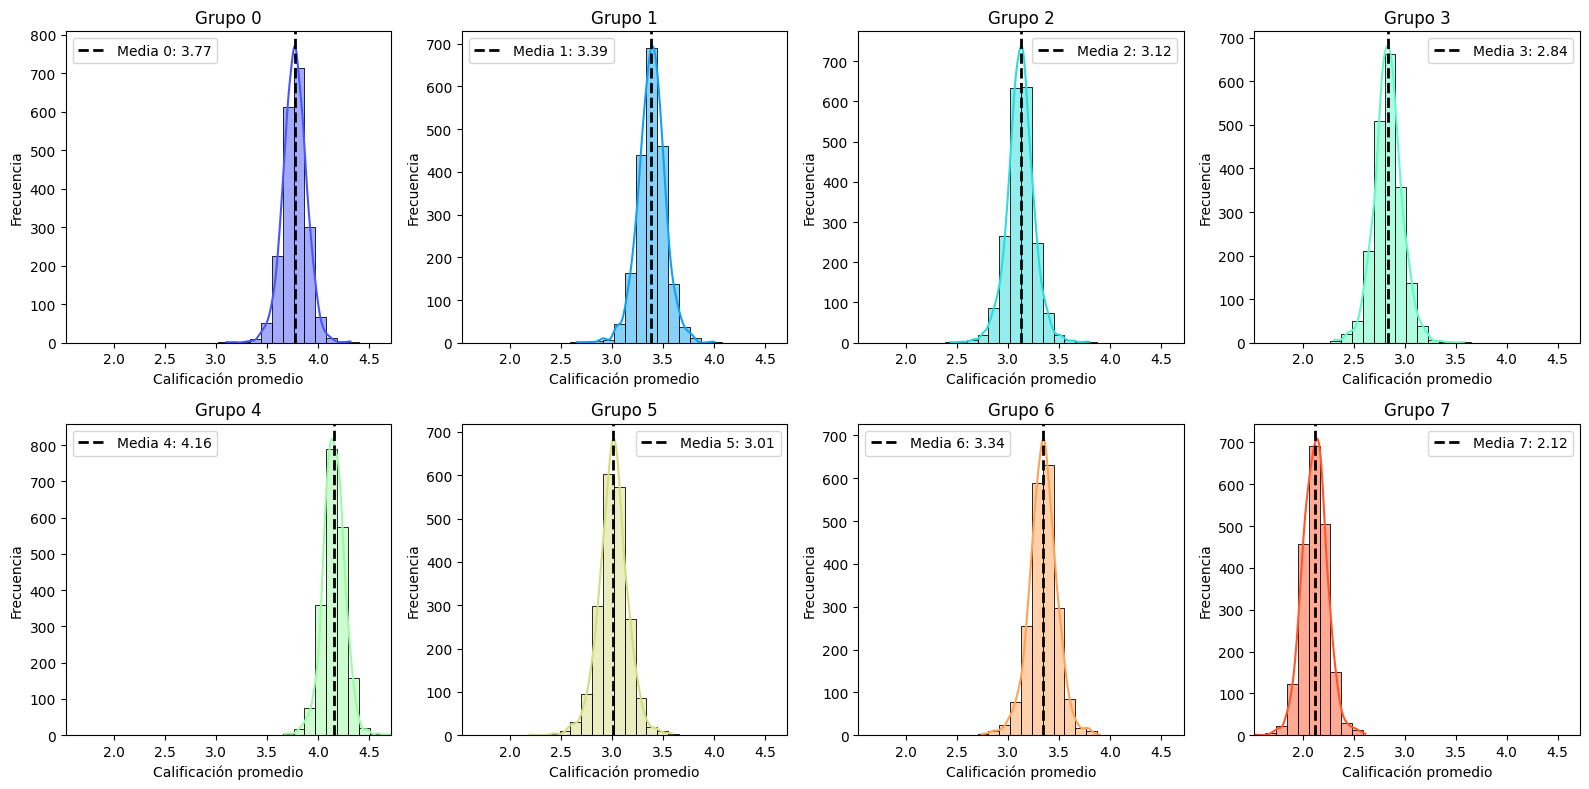

In [43]:
group_mean = training_data.groupby('user_group')['average_user_rating'].mean()
groups = sorted(training_data['user_group'].unique())
x_min, x_max = training_data['average_user_rating'].min(), training_data['average_user_rating'].max()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
palette = sns.color_palette('rainbow', len(groups))

for ax, grp, color in zip(axes.flatten(), groups, palette):
    data_grp = training_data.loc[training_data['user_group'] == grp, 'average_user_rating']
    sns.histplot(data_grp, bins=30, binrange=(x_min, x_max), kde=True, ax=ax, color=color)
    ax.axvline(group_mean[grp], color='black', linestyle='--', linewidth=2, label=f'Media {grp}: {group_mean[grp]:.2f}')
    ax.set_title(f'Grupo {int(grp)}')
    ax.set_xlabel('Calificación promedio')
    ax.set_ylabel('Frecuencia')
    ax.set_xlim(x_min, x_max)
    ax.legend()

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.tight_layout()

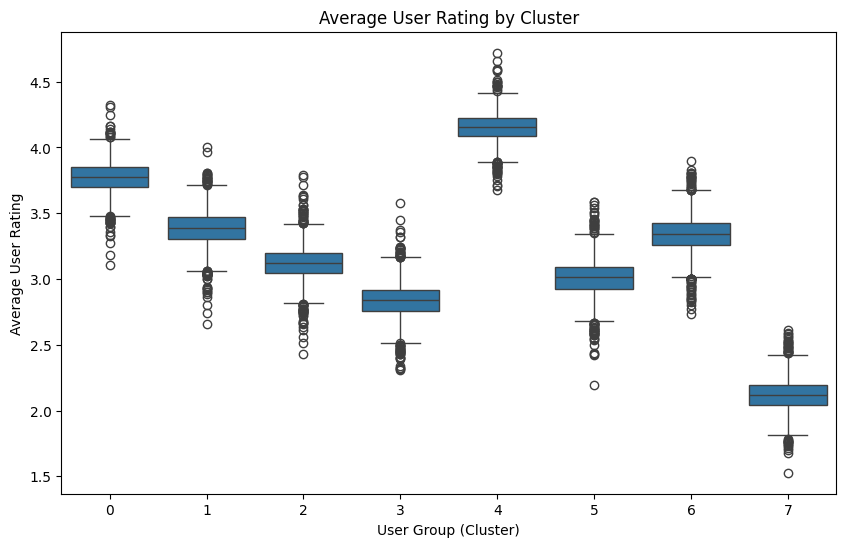

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=training_data, x='user_group', y='average_user_rating')
plt.xlabel('User Group (Cluster)')
plt.ylabel('Average User Rating')
plt.title('Average User Rating by Cluster')
plt.show()

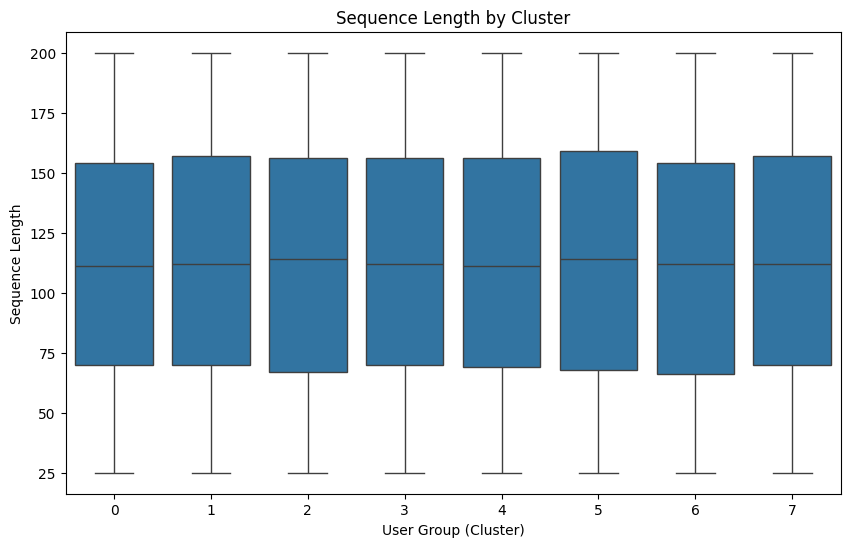

In [45]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=training_data, x='user_group', y='len_sequence')
plt.xlabel('User Group (Cluster)')
plt.ylabel('Sequence Length')
plt.title('Sequence Length by Cluster')
plt.show()

     item_id    rating  frequency
697      101  2.287886       2237
306      317  3.441799       2268
527      462  2.839577       2269
373      515  3.272687       2270
125      124  3.811404       2280
..       ...       ...        ...
388      589  3.253487       2509
26       532  4.303187       2510
694      420  2.297932       2514
649      579  2.418669       2539
307      505  3.439811       2542

[752 rows x 3 columns]


<Axes: xlabel='rating', ylabel='Count'>

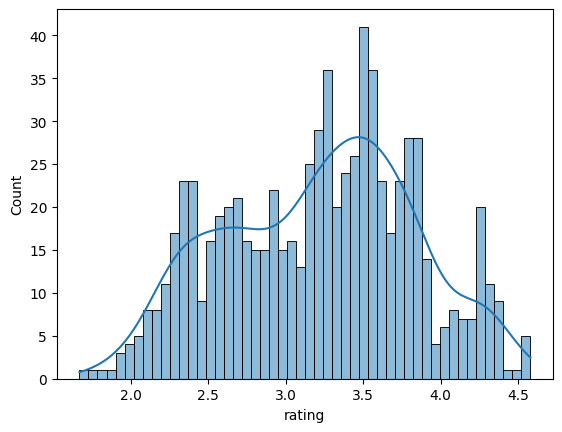

In [46]:
df_expanded = (
    training_data
    .explode(['items', 'ratings'])
    .rename(columns={'items':'item_id', 'ratings':'rating'})
)

item_mean_df = (
    df_expanded
    .groupby('item_id')['rating']
    .mean()
    .reset_index()
    .sort_values('rating', ascending=False)
)

item_freq = df_expanded['item_id'].value_counts().reset_index()
item_freq.columns = ['item_id', 'frequency']

item_mean_df = item_mean_df.merge(item_freq, on='item_id')
item_mean_df = item_mean_df.sort_values('frequency', ascending=True)

print(item_mean_df)

sns.histplot(item_mean_df['rating'], bins=50, kde=True)


Text(0.5, 1.0, 'Distribución de frecuencias de ítems')

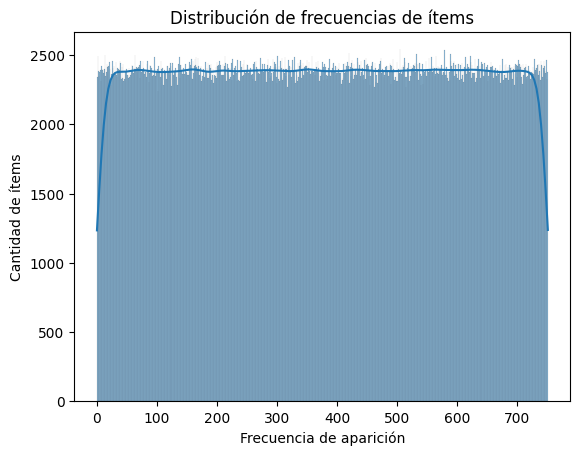

In [47]:
item_freq = df_expanded['item_id'].value_counts()
sns.histplot(df_expanded['item_id'], bins=752, kde=True)
plt.xlabel('Frecuencia de aparición')
plt.ylabel('Cantidad de ítems')
plt.title('Distribución de frecuencias de ítems')


In [48]:
top20 = df_expanded['item_id'].value_counts().head(20)
top20_df = top20.reset_index()
top20_df.columns = ['item_id', 'frequency']
print('Top-20 items por frecuencia:')
top20_df

Top-20 items por frecuencia:


,item_id,frequency
0,505,2542
1,579,2539
2,420,2514
3,532,2510
4,589,2509
5,63,2502
6,13,2499
7,622,2495
8,358,2494
9,213,2491


Correlación entre frecuencia y calificación promedio: -0.0324


<Axes: xlabel='frequency', ylabel='rating'>

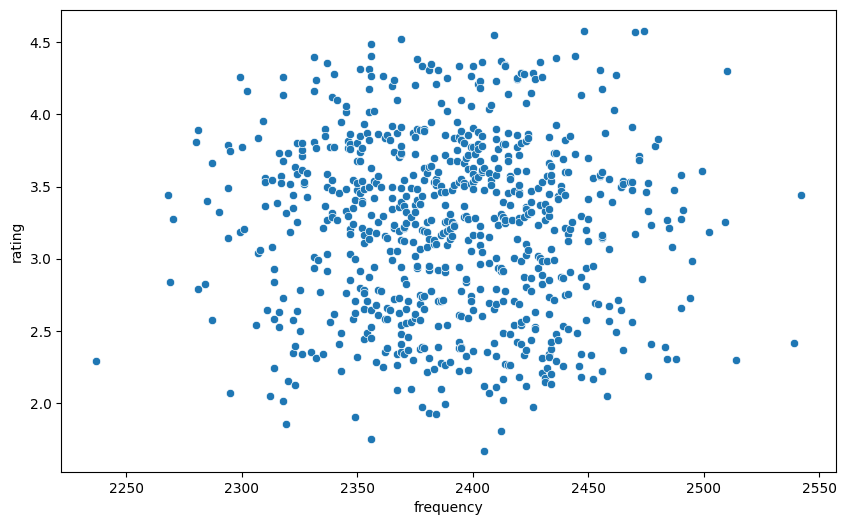

In [49]:
correlation = item_mean_df['frequency'].corr(item_mean_df['rating'])
print(f'Correlación entre frecuencia y calificación promedio: {correlation:.4f}')

df_expanded.head()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=item_mean_df, x='frequency', y='rating')

## 1.3 Pre-procesamiento de datos de entrenamiento
Convertimos el DataFrame en trayectorias listas para el Decision Transformer: expandimos las secuencias, calculamos `returns_to_go` y normalizamos formatos para que cada usuario quede representado como una trayectoria autocontenida.

Número de trayectorias generadas: 16000
Longitud media de las trayectorias: 112.35
Longitud máxima de las trayectorias: 200
Longitud mínima de las trayectorias: 25


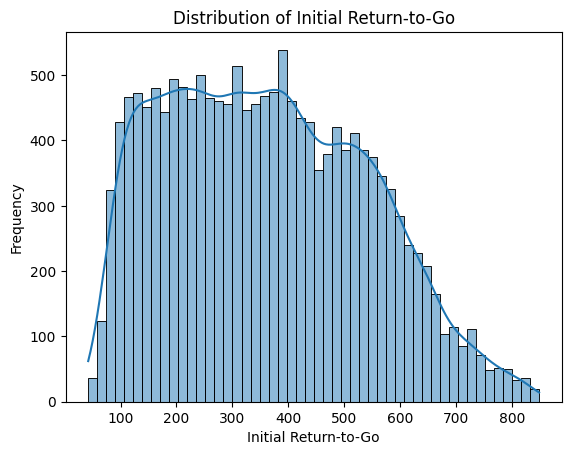

In [50]:
dt_dataset = create_dt_dataset(training_data,test=True, print_stats=True)

initial_rewards = [seq['returns_to_go'][0] for seq in dt_dataset]

sns.histplot(initial_rewards, bins=50, kde=True)
plt.xlabel('Initial Return-to-Go')
plt.ylabel('Frequency')
plt.title('Distribution of Initial Return-to-Go')
plt.show()

#### Guardado
Guardamos las trayectorias generadas como `trajectories_train.pkl` en `data/processed` para reutilizarlas en entrenamiento, validación o futuros experimentos sin recalcular el pipeline.

In [51]:
os.makedirs('../data/processed', exist_ok=True)

with open('../data/processed/trajectories_train.pkl', 'wb') as f:
    pickle.dump(dt_dataset, f)